In [1]:
import nltk
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

matplotlib.rc('font', size=12)
matplotlib.rc('axes', titlesize=12, labelsize=12)

/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [80]:
data = pd.read_csv('../data/fulltrain.csv', header=None)
data.columns = ['cls', 'text']
data['cls'] = data['cls'] - 1
data.head()

,cls,text
0,0,"A little less than a decade ago, hockey fans w..."
1,0,The writers of the HBO series The Sopranos too...
2,0,Despite claims from the TV news outlet to offe...
3,0,After receiving 'subpar' service and experienc...
4,0,After watching his beloved Seattle Mariners pr...


In [81]:
data.shape

(48854, 2)

In [122]:
data = data.drop_duplicates()
data.shape

(48652, 3)

In [120]:
cls_names = { 0 : "Satire", 1 : "Hoax", 2 : "Propaganda", 3 : "Reliable"}
data['cls'].map(cls_names).value_counts()

Propaganda    17870
Satire        13911
Reliable       9932
Hoax           6939
Name: cls, dtype: int64

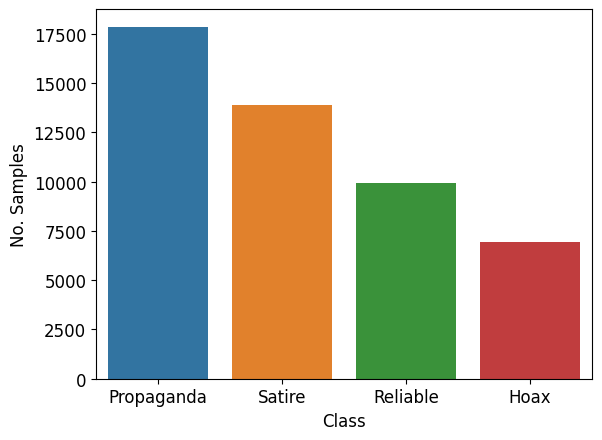

In [177]:
cls_counts = data['cls'].map(cls_names).value_counts()
sns.barplot(x=cls_counts.index, y=cls_counts.values)
plt.ylabel('No. Samples')
plt.xlabel('Class')
plt.savefig('../figures/class_count.jpg', dpi=300, bbox_inches='tight')
plt.show()

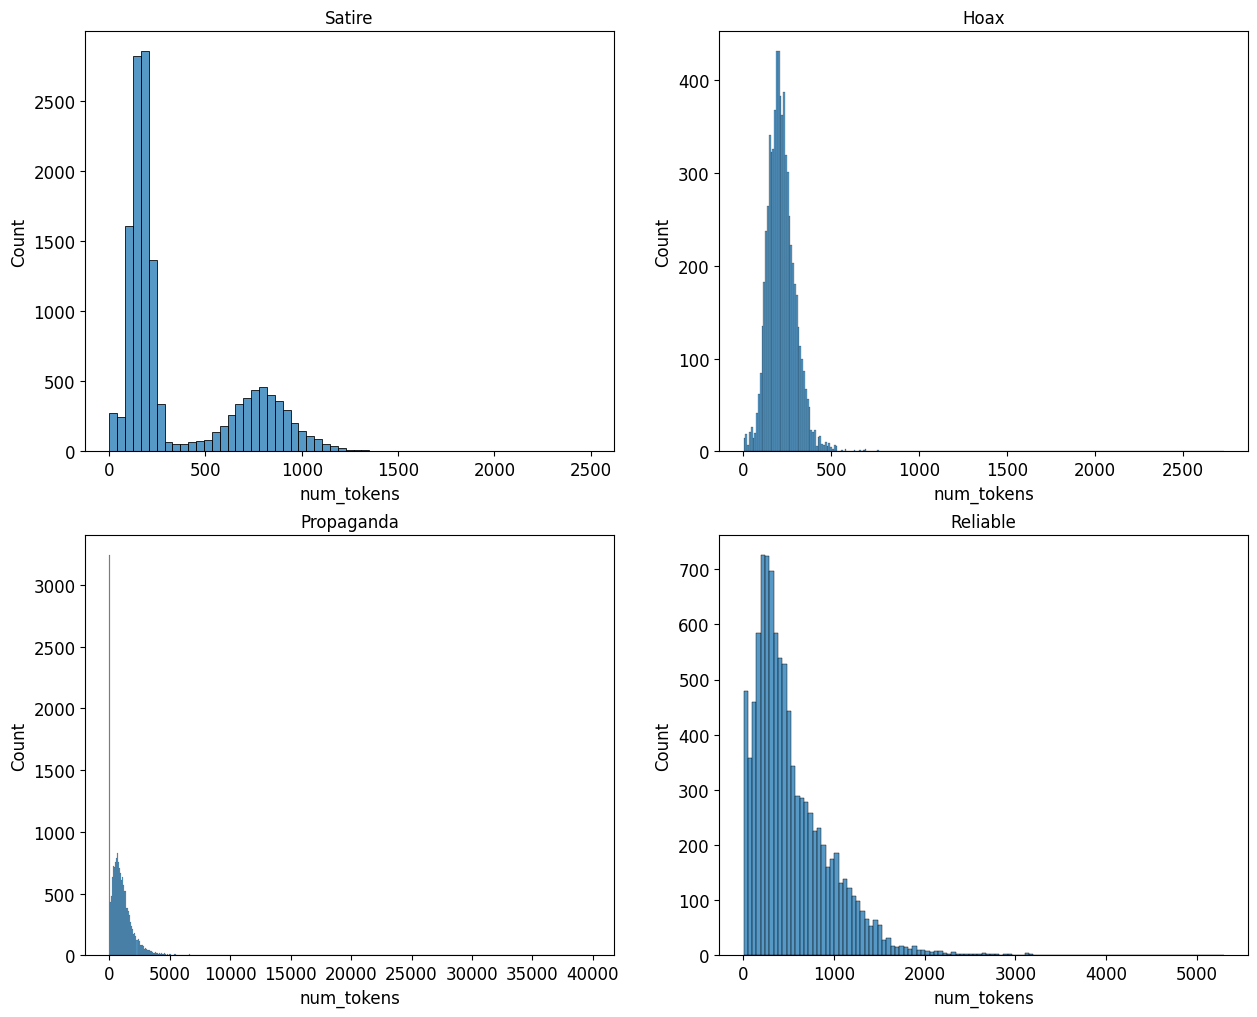

In [146]:
data['num_tokens'] = data['text'].apply(lambda x: len(wordpunct_tokenize(x)))

fig, ax = plt.subplots(2, 2, figsize=(15, 12))
for cls in range(4):
    x, y = cls // 2, cls % 2
    sns.histplot(data[data['cls'] == cls]['num_tokens'], ax=ax[x][y], label=cls_names[cls])
    ax[x][y].title.set_text(cls_names[cls])
    
plt.show()

In [124]:
test_data = pd.read_csv('../data/balancedtest.csv', header=None)
test_data.columns = ['cls', 'text']
test_data['cls'] = test_data['cls'] - 1
test_data['cls'].map(cls_names).value_counts()

Satire        750
Hoax          750
Propaganda    750
Reliable      750
Name: cls, dtype: int64

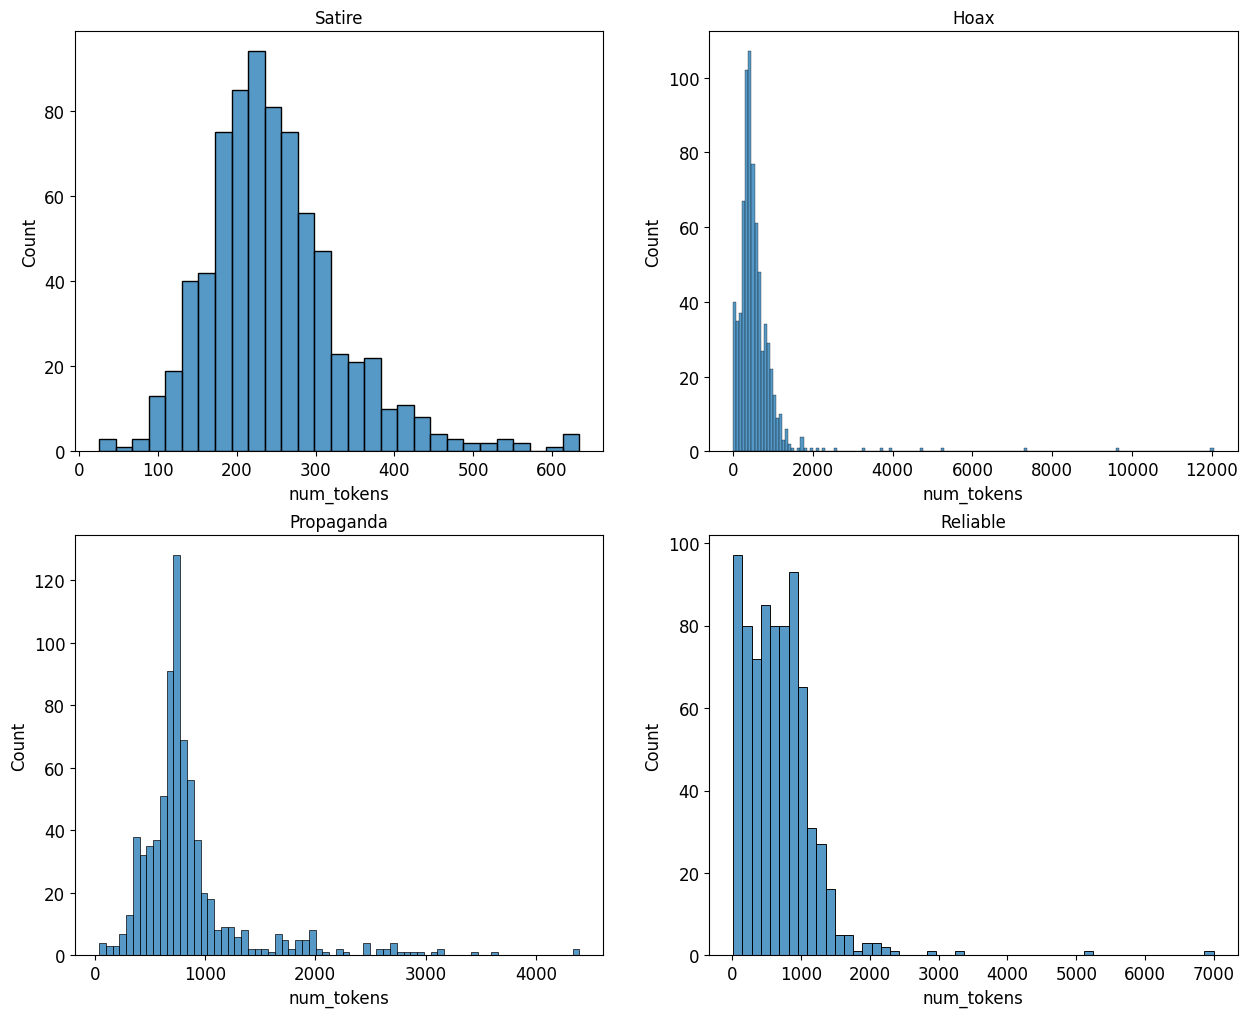

In [125]:
test_data['num_tokens'] = test_data['text'].apply(lambda x: len(wordpunct_tokenize(x)))

fig, ax = plt.subplots(2, 2, figsize=(15, 12))
for cls in range(4):
    x, y = cls // 2, cls % 2
    sns.histplot(test_data[test_data['cls'] == cls]['num_tokens'], ax=ax[x][y], label=cls_names[cls])
    ax[x][y].title.set_text(cls_names[cls])
    
plt.show()

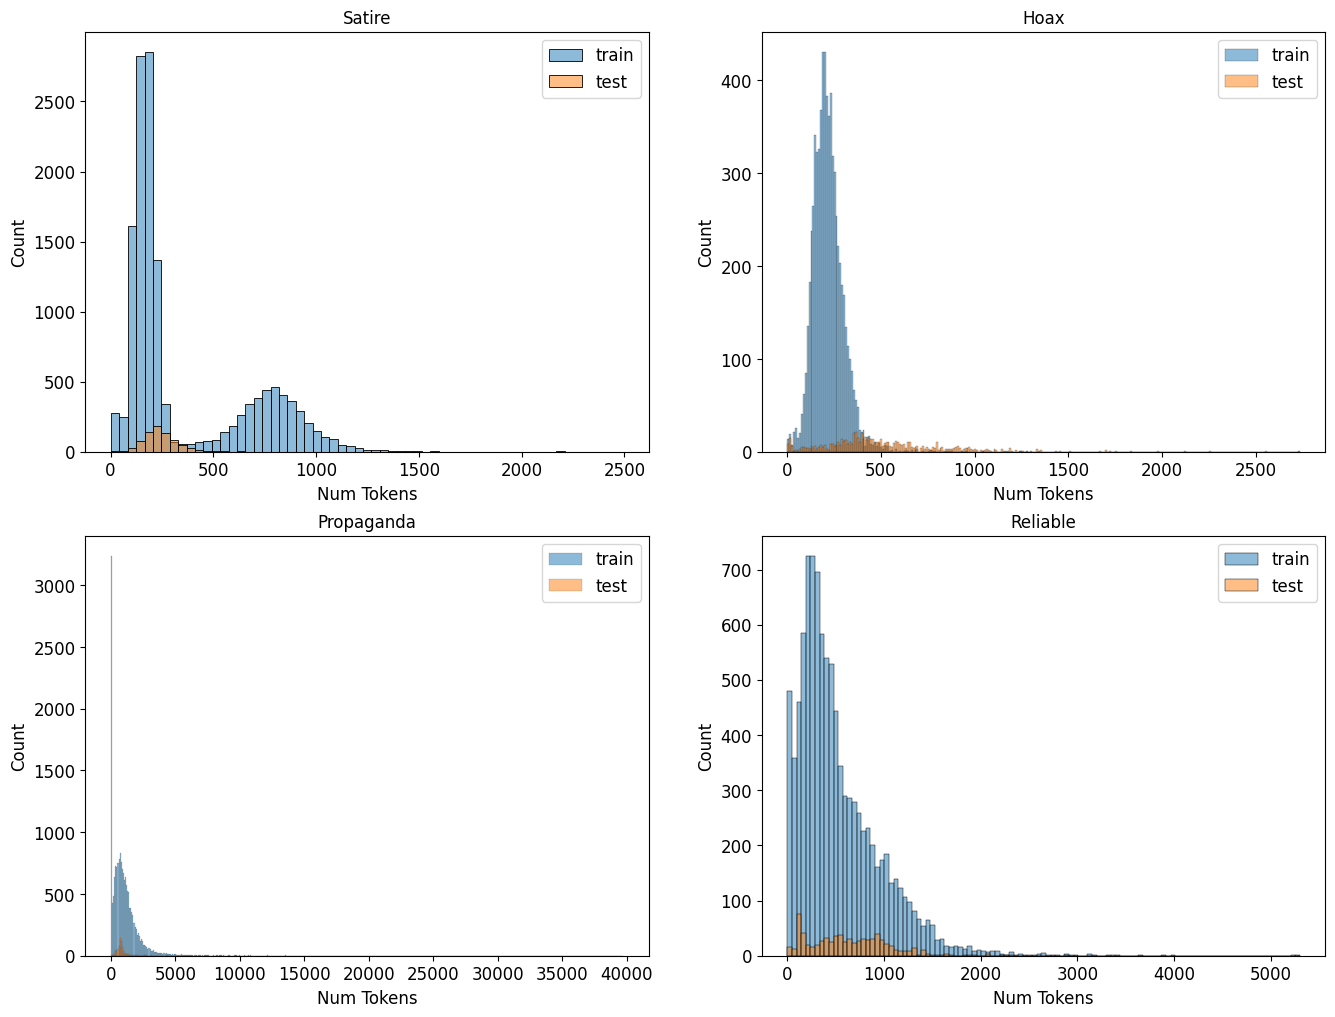

In [145]:
data['num_tokens'] = data['text'].apply(lambda x: len(wordpunct_tokenize(x)))
data = data[data['num_tokens'] < 50000]

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
for cls in range(4):
    x, y = cls // 2, cls % 2
    bins = np.histogram_bin_edges(data[data['cls'] == cls]['num_tokens'], bins='auto')
    sns.histplot(data[data['cls'] == cls]['num_tokens'], alpha=0.5, bins=bins, ax=ax[x][y], label='train')
    sns.histplot(test_data[test_data['cls'] == cls]['num_tokens'], alpha=0.5, bins=bins, ax=ax[x][y], label='test')
    ax[x][y].title.set_text(cls_names[cls])
    ax[x][y].set_xlabel('Num Tokens')
    ax[x][y].legend(loc='upper right')

plt.savefig('../figures/doclens.jpg', dpi=300)
plt.show()

In [86]:
data['num_tokens'] = data['text'].apply(lambda x: len(wordpunct_tokenize(x)))

In [91]:
data[data['num_tokens'] < 100]['cls'].value_counts()

2    3316
0     973
3     861
1     263
Name: cls, dtype: int64

In [16]:
test_data['num_tokens'] = test_data['text'].apply(lambda x: len(wordpunct_tokenize(x)))
test_data[test_data['num_tokens'] < 10]['cls'].value_counts()

1    5
Name: cls, dtype: int64

## N-Gram Distribution Analysis

In [59]:
top_keywords = {}
top_counts = {}

for y, name in cls_names.items():
    
    cls_docs = data[data.cls == y]['text'].tolist()
    
    cvect = CountVectorizer(
        ngram_range=(1, 2),
        stop_words=stopwords.words('english'),
        max_df=0.8,
        min_df=10,
        max_features=5096
    )
    
    tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words=stopwords.words('english'),
        max_df=0.8,
        min_df=10,
        max_features=5096
    )
    
    tfidf_vect = tfidf.fit_transform(cls_docs).toarray().sum(axis=0)
    tfidf_terms = np.array(tfidf.get_feature_names_out())
    tfidf_terms = tfidf_terms[np.argsort(tfidf_vect)[::-1]].tolist()
    tfidf_values = np.sort(tfidf_vect)[::-1].round(2).tolist()
    top_tfidf = list(zip(tfidf_terms, tfidf_values))
    
    sum_words = cvect.fit_transform(cls_docs).sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cvect.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    print('Class', name)
    print('Top by Count', words_freq[:20])
    print('Top by TFIDF', top_tfidf[:20])
    
    top_keywords[name] = top_tfidf[:5000]
    top_counts[name] = words_freq[:5000]

Class Satire
Top by Count [('one', 11426), ('time', 11092), ('would', 9736), ('like', 9278), ('new', 7558), ('year', 7120), ('even', 6508), ('added', 6302), ('get', 6298), ('could', 6163), ('people', 5741), ('amp', 5241), ('amp amp', 5196), ('first', 5175), ('also', 5140), ('old', 5132), ('monday', 5079), ('day', 4879), ('really', 4872), ('years', 4834)]
Top by TFIDF [('time', 308.31), ('one', 302.49), ('would', 287.22), ('like', 269.29), ('new', 249.81), ('year', 239.53), ('monday', 216.66), ('get', 213.23), ('could', 206.04), ('even', 199.32), ('old', 196.62), ('people', 188.42), ('sources', 183.76), ('really', 183.12), ('back', 180.88), ('added', 180.42), ('day', 177.04), ('first', 176.72), ('told', 172.74), ('know', 170.77)]
Class Hoax
Top by Count [('obama', 7069), ('think', 6185), ('trump', 4915), ('one', 3612), ('president', 3583), ('according', 3194), ('video', 3052), ('people', 2878), ('would', 2770), ('reports', 2768), ('time', 2583), ('told', 2311), ('country', 2214), ('clin

In [60]:
mat = []

for cls1 in cls_names.values():
    mat_row = []
    for cls2 in cls_names.values():
        cls1_keywords = [x[0] for x in top_keywords[cls1]]
        cls2_keywords = [x[0] for x in top_keywords[cls2]]
        intersect = len(set(cls1_keywords).intersection(cls2_keywords))
        mat_row.append(intersect / 5000)
    mat.append(mat_row)

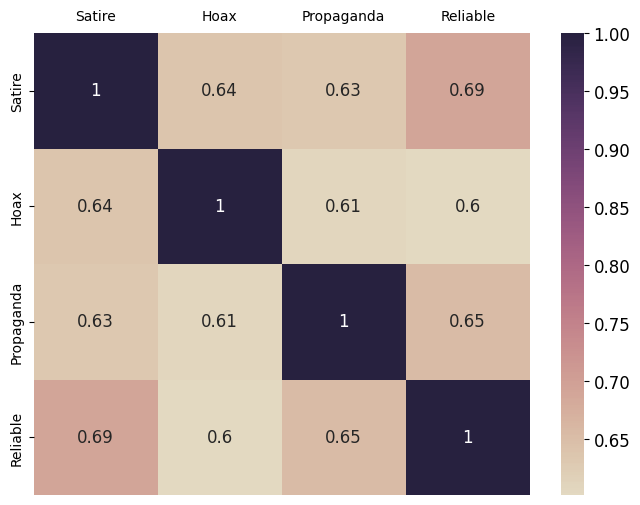

In [75]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.figure(figsize=(8, 6))
sns.heatmap(mat, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), xticklabels=cls_names.values(), yticklabels=cls_names.values(), annot=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.savefig('../figures/tfidf_heatmap.jpg', dpi=300)
plt.show()